### Task 2: Clustering 

In [1]:
# importing libaries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift 
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
#loading dataset
df = pd.read_csv('country_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


#### Note: 
This data is also on different scales example: 
1. Income is measured in currency <br>
2. Inflation is measured in % <br>
3. Exports and import can either be measured in the country unit <br>
4. Health can also be measured through various unit <br>
5. Life expectancy is measured in years <br>
6. Total fertility is measured in the unit of births per woman <br>
7. Gdpp is measured in country currency 

In [3]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


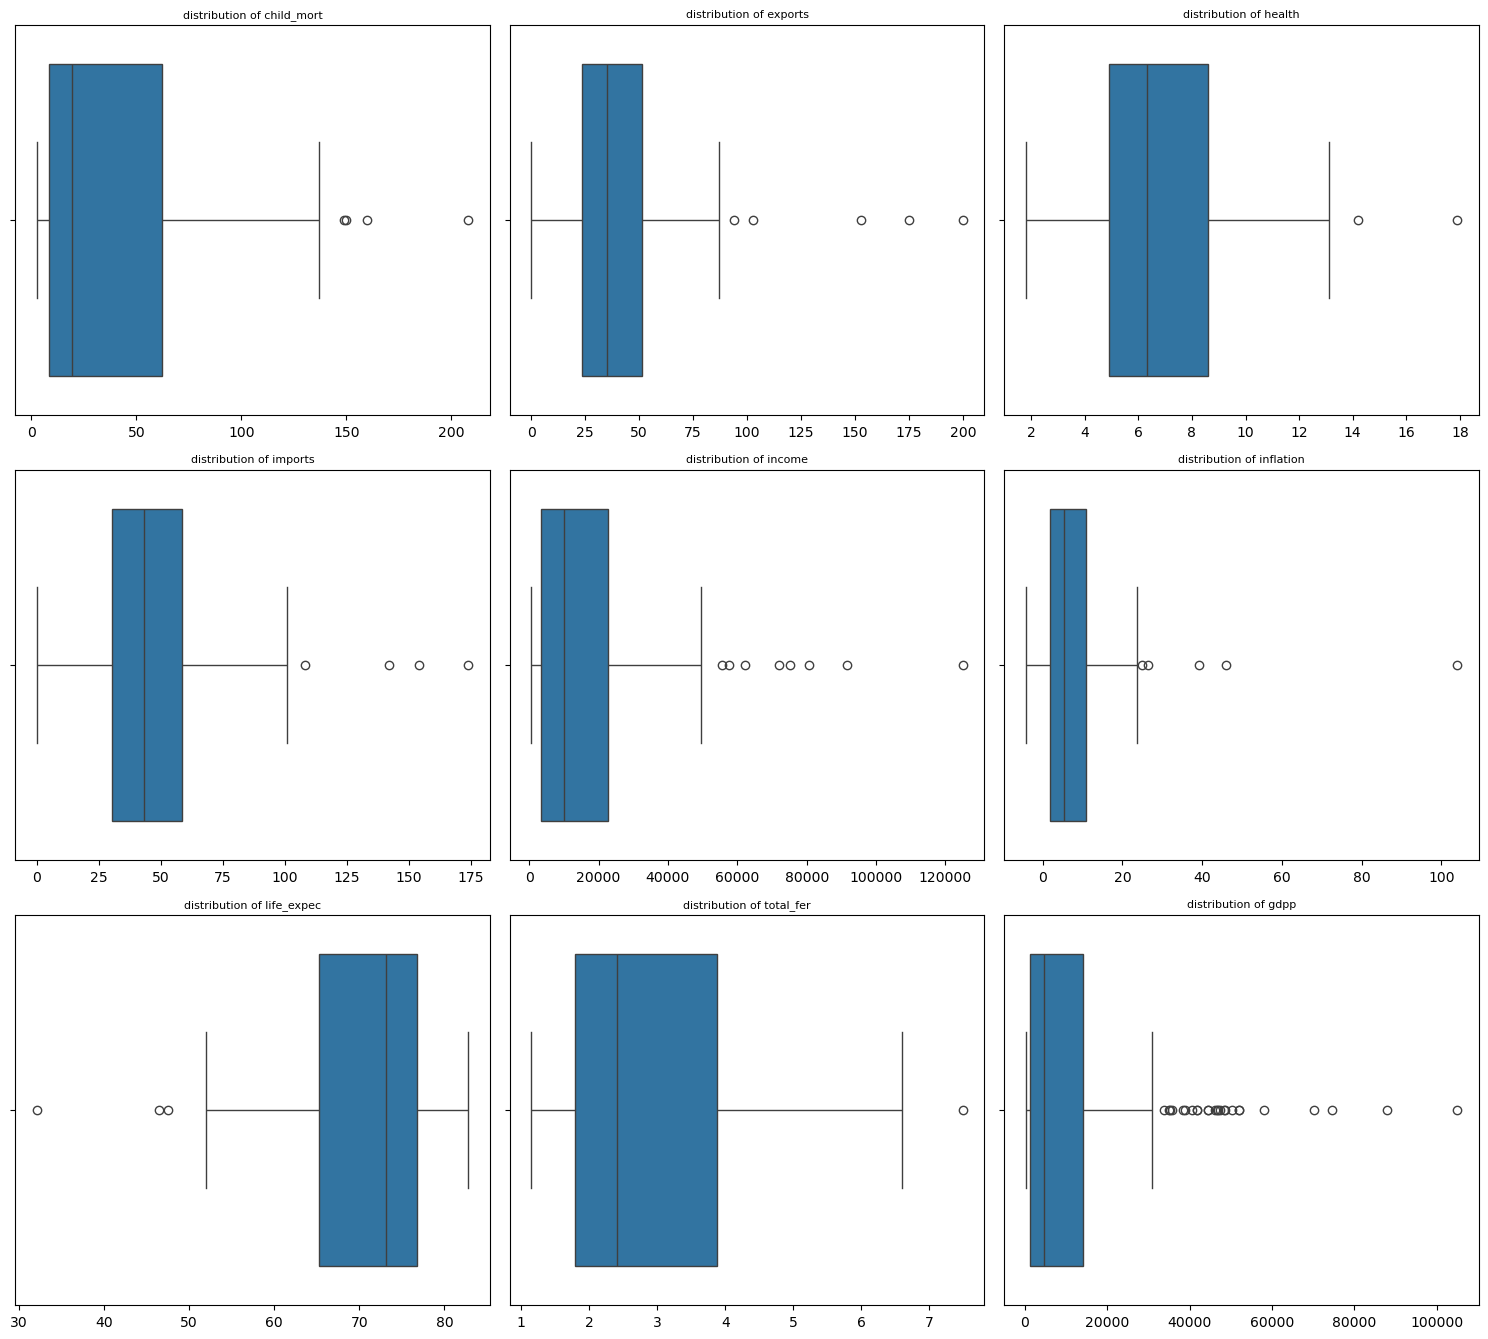

In [4]:
#calculating grid size
numeric_df = df.select_dtypes(include = 'number')
variables = [col for col in numeric_df.columns]

num_variables = len(variables)
cols = 3 
rows = (num_variables + cols -1) // cols

fig, axes = plt.subplots(nrows = rows, ncols = cols, figsize = (5* cols, 4.5 * rows))
axes = axes.flatten()

for i, col in enumerate(variables):
    sns.boxplot(x= numeric_df[col], ax=axes[i])
    axes[i].set_title(f"distribution of {col}", fontsize = 8)
    axes[i].set_xlabel("")

for j in range (i + 1, len(axes)):
    fig.delaxes(axes[j])
fig.tight_layout()
plt.show()

In [5]:
# --- 2. Statistical Outlier Detection (IQR Method) ---
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Identify where values are outside these bounds
outliers = ((numeric_df < lower_limit) | (numeric_df > upper_limit))

# Count outliers per column
outlier_counts = outliers.sum().sort_values(ascending=False)

print("\nNumber of Outliers per Feature:")
print(outlier_counts)


Number of Outliers per Feature:
gdpp          25
income         8
exports        5
inflation      5
child_mort     4
imports        4
life_expec     3
health         2
total_fer      1
dtype: int64


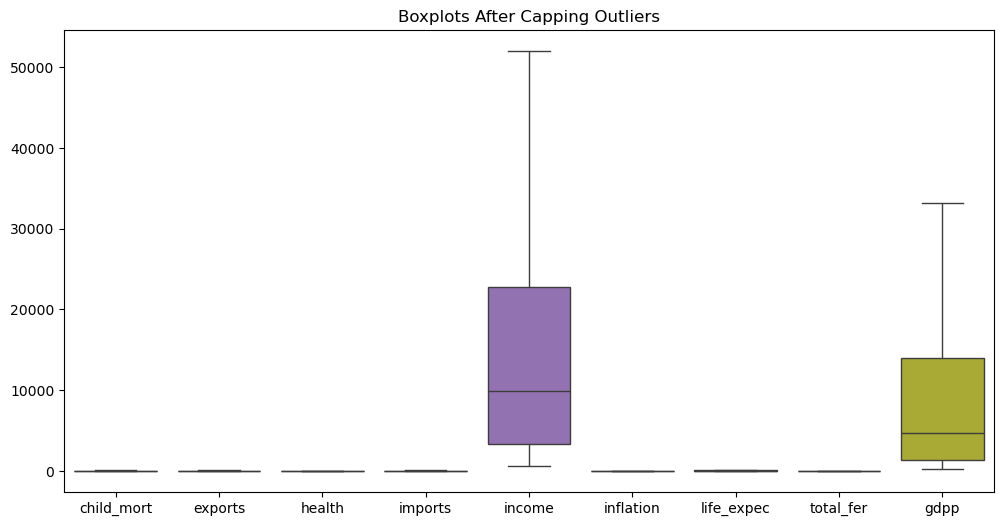

In [6]:
# Winsorization using IQR
# Compute IQR bounds again
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Cap values
df_capped = numeric_df.copy()
for col in numeric_df.columns:
    df_capped[col] = numeric_df[col].clip(lower=lower_limit[col], upper=upper_limit[col])

# Confirm capping worked
plt.figure(figsize=(12,6))
sns.boxplot(data=df_capped)
plt.title("Boxplots After Capping Outliers")
plt.show()

In [7]:
# Check skewness of each numeric column
skewness = df_capped.skew().sort_values(ascending=False)
print("Skewness of Each Feature:")
print(skewness)

Skewness of Each Feature:
child_mort    1.197712
gdpp          1.115232
income        1.040602
inflation     0.966714
total_fer     0.941084
exports       0.698211
imports       0.673252
health        0.480173
life_expec   -0.660644
dtype: float64


In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_capped)

# Conversion too DataFrame for easier reference
X_scaled = pd.DataFrame(X_scaled, columns=df_capped.columns)
X_scaled

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.369802,-1.391107,0.296013,-0.047444,-0.943936,0.355270,-1.702225,1.915276,-0.846341
1,-0.550464,-0.543547,-0.091190,0.135021,-0.395181,-0.385208,0.663321,-0.862779,-0.540827
2,-0.271295,-0.053846,-0.985893,-0.713196,-0.199291,1.351551,0.686859,-0.036691,-0.508868
3,2.121210,1.071524,-1.482114,-0.146074,-0.660984,2.293979,-1.243238,2.141784,-0.589198
4,-0.714835,0.280469,-0.286671,0.642965,0.209637,-0.841463,0.722166,-0.543003,0.159686
...,...,...,...,...,...,...,...,...,...
162,-0.221723,0.332264,-0.579893,0.337212,-0.855555,-0.664945,-0.901941,0.369691,-0.637569
163,-0.537419,-0.520004,-0.707708,-1.393742,0.038151,2.557260,0.557401,-0.316495,0.271975
164,-0.375657,1.528265,0.017828,1.693373,-0.753982,0.753184,0.286717,-0.662919,-0.780954
165,0.485332,-0.449374,-0.606208,-0.565251,-0.754642,2.473489,-0.372341,1.149146,-0.780954


#### Building model with Health Metrics 
From visual overview we can group our data into two key classes <br> 
1. Health Metrics in our dataset- Health, life expectancy, total fertility, child mortality <br>
2. Economic metrics - Export, imports, income, inflation and gdpp

Text(0, 0.5, 'child_mort')

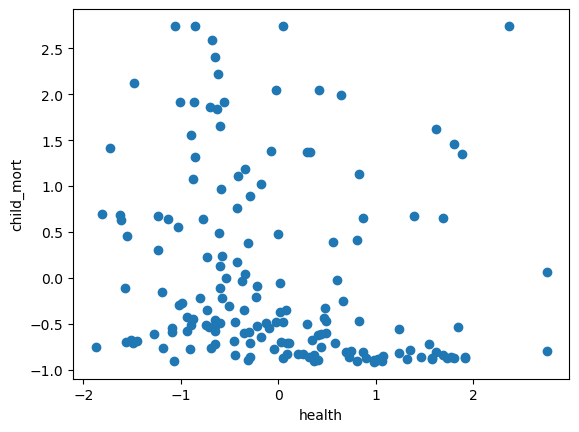

In [9]:
#Building model with 2 Health Features 
# lets look at heath features 
X_two = X_scaled[['health', 'child_mort']]

fig, ax = plt.subplots()
ax.scatter(X_scaled['health'], X_scaled['child_mort'])
ax.set_xlabel('health')
ax.set_ylabel('child_mort')

##### Based On visul inspection it's not clear how many clusters this feature should have. But i can assume 4 features based on the clustering at the lower ends. However to make a decision Silhouette score will be used to determine the number of clusters

Optimal number of clusters (based on silhouette score): 4


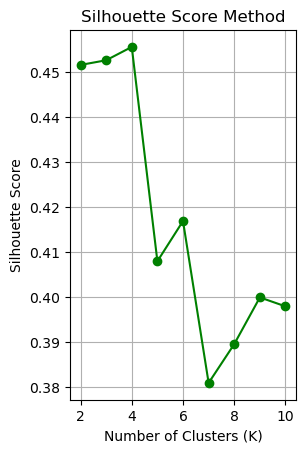

In [10]:
from sklearn.metrics import silhouette_score
silhouette_scores = []

K = range(2, 11)

for k in K:
    kmeans = KMeans (n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_two)
    score = silhouette_score(X_two, kmeans.labels_)
    silhouette_scores.append(score)

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'o-', color='green')
plt.title('Silhouette Score Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)

# Print the K with the highest silhouette score
best_k = K[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters (based on silhouette score): {best_k}")

In [11]:
# silhouette score optimal number of cluster is 4
kmeans = KMeans(n_clusters = 4, n_init = 'auto', random_state=42)

kmeans.fit(X_two)

kmcenters = kmeans.cluster_centers_
print('Centroids: \n', kmcenters)

Centroids: 
 [[ 0.13413504 -0.56425495]
 [-0.30746464  1.73906507]
 [ 1.42274511 -0.51748863]
 [-0.95905144 -0.18743999]]


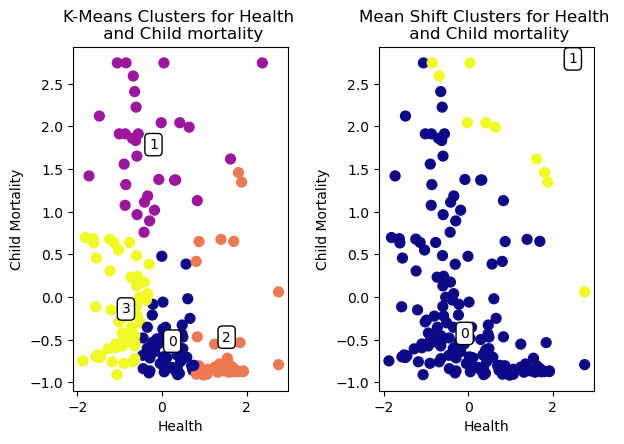

In [12]:
ms = MeanShift()
ms.fit(X_two)
mscenters = ms.cluster_centers_

fig, ax = plt.subplots(1, 2)

nm1 = Normalize(vmin =0, vmax = len(kmcenters)-1) # Count at 0 and count all the list of centriods minus 1

ax[0].scatter(X_two['health'], X_two['child_mort'], c = kmeans.predict(X_two), s = 50, cmap = 'plasma', norm = nm1)

#for loop to label clusters
for i in range(kmcenters.shape[0]):
    ax[0].text(kmcenters[i,0], kmcenters[i,1], str(i), c ='black',
            bbox = dict(boxstyle = 'round', facecolor = 'white', edgecolor = 'black'))

ax[0].set_xlabel('Health')
ax[0].set_ylabel('Child Mortality')
ax[0].set_title('K-Means Clusters for Health \n and Child mortality')

nm2 = Normalize(vmin =0, vmax = len(mscenters)-1) # Count at 0 and count all the list of centriods minus 1

ax[1].scatter(X_two['health'], X_two['child_mort'], c = ms.predict(X_two), s = 50, cmap = 'plasma', norm = nm2)

#for loop to label clusters
for i in range(mscenters.shape[0]):
    ax[1].text(mscenters[i,0], mscenters[i,1], str(i), c ='black',
            bbox = dict(boxstyle = 'round', facecolor = 'white', edgecolor = 'black'))

ax[1].set_xlabel('Health')
ax[1].set_ylabel('Child Mortality')
ax[1].set_title('Mean Shift Clusters for Health \n and Child mortality')

plt.tight_layout(pad =2.0)

In [13]:
X_two_viz = pd.DataFrame ({ 
    'health': X_scaled['health'],
    'child_mort': X_scaled['child_mort']
})

#attaching country 
X_two_viz['country'] = df['country'].values

#adding cluster labels from trained model
X_two_viz['cluster'] = kmeans.labels_

X_two_viz.head()

,health,child_mort,country,cluster
0,0.296013,1.369802,Afghanistan,1
1,-0.091190,-0.550464,Albania,0
2,-0.985893,-0.271295,Algeria,3
3,-1.482114,2.121210,Angola,1
4,-0.286671,-0.714835,Antigua and Barbuda,0


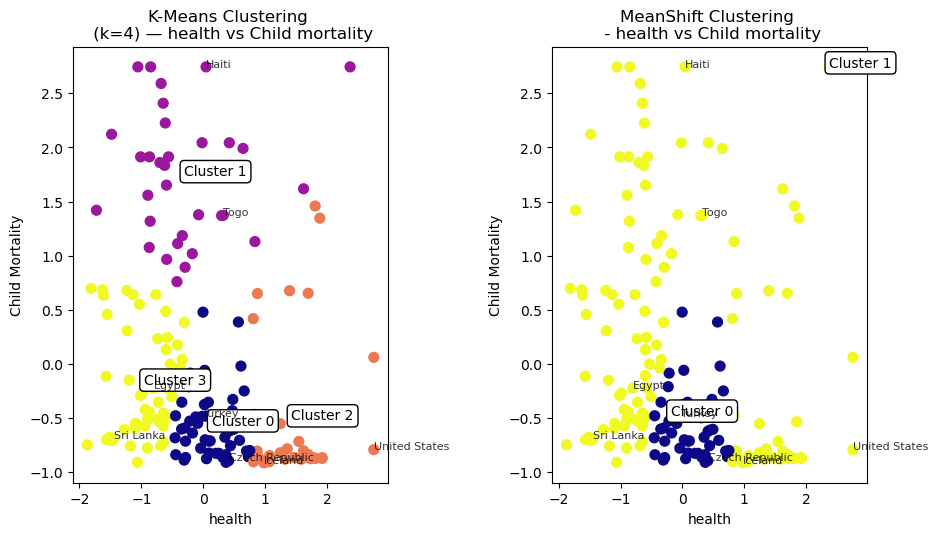

In [14]:
fig, ax = plt.subplots(1, 2, figsize =(10,6))

nm1 = Normalize(vmin =0, vmax = len(kmcenters)-1) # Count at 0 and count all the list of centriods minus 1

ax[0].scatter(X_two['health'], X_two['child_mort'], c = X_two_viz['cluster'], s = 50, cmap = 'plasma', norm = nm1)

#for loop to label clusters
for i in range(kmcenters.shape[0]):
    ax[0].text(kmcenters[i,0], kmcenters[i,1], f'Cluster {i}', c ='black',
            bbox = dict(boxstyle = 'round', facecolor = 'white', edgecolor = 'black'))

#countries
for cluster_id in X_two_viz['cluster'].unique():
    subset = X_two_viz[X_two_viz['cluster'] == cluster_id].sample(2, random_state = 42)
    for _, row in subset.iterrows():
        ax[0].text(row['health'], row['child_mort'], row['country'],
                fontsize=8, c='black', alpha=0.8)

ax[0].set_xlabel('health')
ax[0].set_ylabel('Child Mortality')
ax[0].set_title(f'K-Means Clustering \n (k={kmeans.n_clusters}) — health vs Child mortality')
#plt.savefig('kmeans_health_childmort.png', dpi=300, bbox_inches='tight')
#plt.show()

nm2 = Normalize(vmin =0, vmax = len(mscenters)-1) # Count at 0 and count all the list of centriods minus 1

ax[1].scatter(X_two['health'], X_two['child_mort'], c = X_two_viz['cluster'], s = 50, cmap = 'plasma', norm = nm2)

#for loop to label clusters
for i in range(mscenters.shape[0]):
    ax[1].text(mscenters[i,0], mscenters[i,1], f'Cluster {i}', c ='black',
            bbox = dict(boxstyle = 'round', facecolor = 'white', edgecolor = 'black'))

#countries
for cluster_id in X_two_viz['cluster'].unique():
    subset = X_two_viz[X_two_viz['cluster'] == cluster_id].sample(2, random_state = 42)
    for _, row in subset.iterrows():
        ax[1].text(row['health'], row['child_mort'], row['country'],
                fontsize=8, c='black', alpha=0.8)

ax[1].set_xlabel('health')
ax[1].set_ylabel('Child Mortality')
ax[1].set_title('MeanShift Clustering \n - health vs Child mortality')
#plt.savefig('health_childmort.png', dpi=300, bbox_inches='tight')
plt.tight_layout(pad = 3.0)
plt.show()

##### Chart above shows a negative relationship between health and Child mortality rate. An increase in the health of a country leads to a decrease in child mortality. K-Means is also more informative by identifying 4 clusters. Countries in Clusters 0,2, and 3 typically have lower child mortality rates, with a few outliers. While countries in Cluster 1, such as Togo, Haiti, have a high child mortality rate

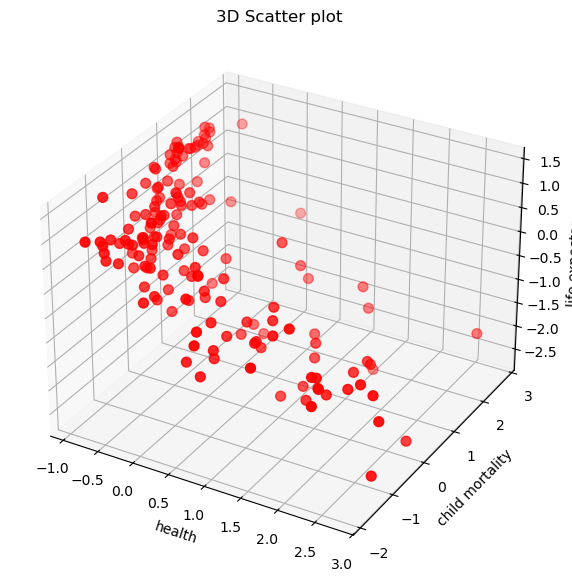

In [15]:
#Building model with 3 Health Features 
# lets look at heath features 
X_three = X_scaled.iloc[:, [0,2,6]].values 


from mpl_toolkits import mplot3d
fig = plt.figure(figsize =(10,7))
ax = plt.axes(projection='3d')
ax.grid()

ax.scatter(X_three[:,0], X_three[:,1], X_three[:,2], c= 'r', s =50)

ax.azim = -60
ax.dist = 10
ax.eleve = 10

plt.title('3D Scatter plot')
ax.set_xlabel('health')
ax.set_ylabel('child mortality')
ax.set_zlabel('life expectancy')

plt.show()

Visual inspection i can assume 2-3 clusters

In [16]:
silhouette_scores = []

K = range(2, 11)

for k in K:
    kmeans = KMeans (n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_three)
    score = silhouette_score(X_three, kmeans.labels_)
    silhouette_scores.append(score)

# Print the K with the highest silhouette score
best_k = K[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters (based on silhouette score): {best_k}")

Optimal number of clusters (based on silhouette score): 2


In [17]:
# silhouette score optimal number of cluster is 2
kmeans = KMeans(n_clusters = 3, n_init = 'auto')

kmeans.fit(X_three[:,[0,1,2]])

kmcenters = kmeans.cluster_centers_
print('Centroids: \n', kmcenters)

Centroids: 
 [[-0.73401907  1.01896928  0.89477603]
 [ 1.48150599 -0.15028902 -1.38542302]
 [-0.35986007 -0.62335624  0.19095359]]


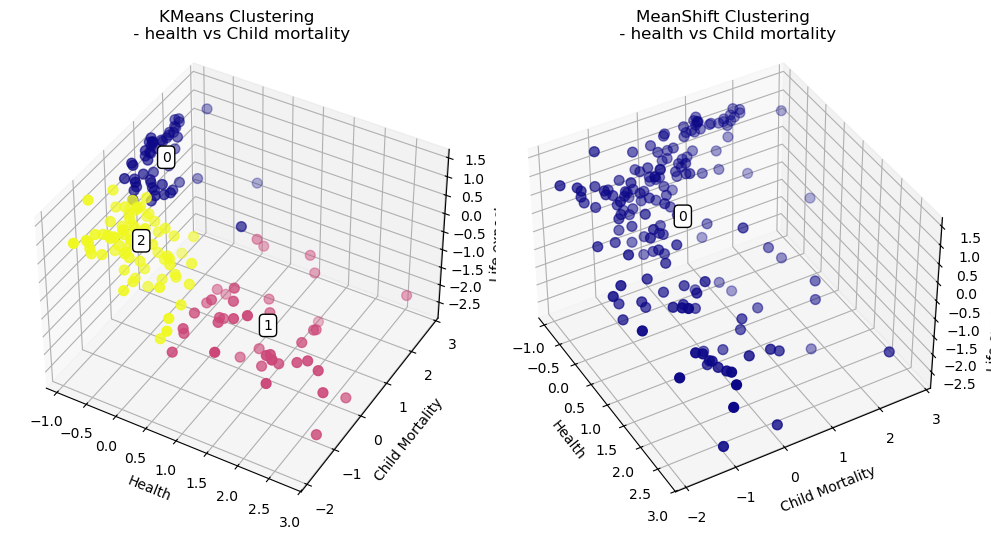

In [18]:
ms = MeanShift( bandwidth= 50)
ms.fit(X_three)
mscenters = ms.cluster_centers_

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1, 2, 1, projection ='3d')
labels1 = kmeans.labels_

ax1.scatter(X_three[:,0], X_three[:,1], X_three[:,2], c = labels1, s =50, cmap='plasma')

for i in range(kmcenters.shape[0]):
    ax1.text(kmcenters[i,0], kmcenters[i,1], kmcenters[i,2], str(i), c = "black", 
            bbox = dict(boxstyle = "round", facecolor = "white", edgecolor = "black"))
ax1.azim = -60
ax1.dist = -10
ax1.elev = 40
ax1.set_xlabel('Health')
ax1.set_ylabel('Child Mortality')
ax1.set_zlabel('Life expectancy')
ax1.set_title('KMeans Clustering \n - health vs Child mortality')

#mean shift plot
ax2 = fig.add_subplot(1,2,2, projection ='3d')
labels2 = ms.labels_

ax2.scatter(X_three[:,0], X_three[:,1], X_three[:,2], c = labels2, s =50, cmap='plasma')

for i in range(mscenters.shape[0]):
    ax2.text(mscenters[i,0], mscenters[i,1], mscenters[i,2], str(i), c = "black", 
            bbox = dict(boxstyle = "round", facecolor = "white", edgecolor = "black"))
ax2.azim = -30
ax2.dist = -10
ax2.elev = 40
ax2.set_xlabel('Health')
ax2.set_ylabel('Child Mortality')
ax2.set_zlabel('Life expectancy')
ax2.set_title('MeanShift Clustering \n - health vs Child mortality')

fig.tight_layout(pad = 2.0)
plt.show()

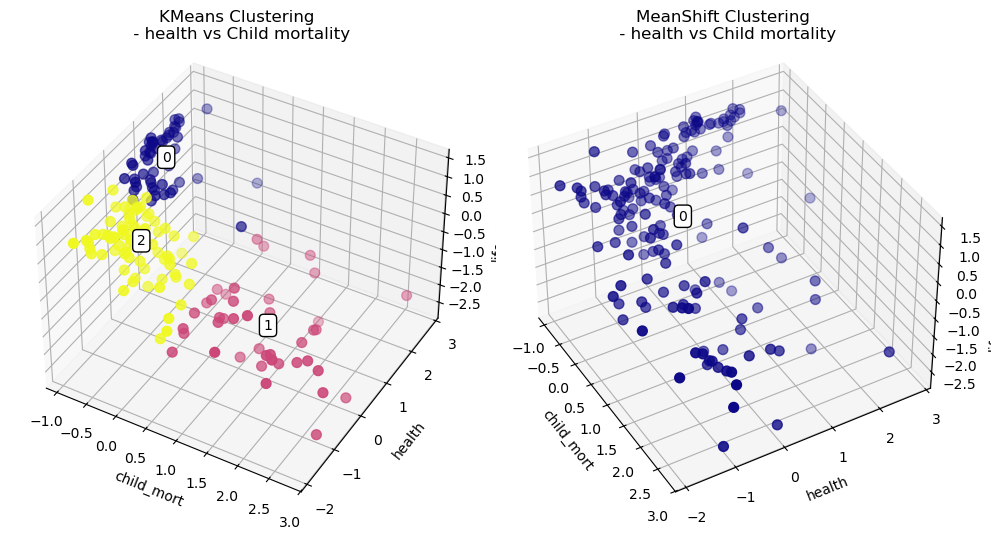

In [19]:
ms = MeanShift( bandwidth= 50)
ms.fit(X_three[:,[0,1,2]])
mscenters = ms.cluster_centers_

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1, 2, 1, projection ='3d')

ax1.scatter(X_three[:,0], X_three[:,1], X_three[:,2], c = kmeans.predict(X_three[:,[0,1,2]]), s =50, cmap='plasma')

for i in range(kmcenters.shape[0]):
    ax1.text(kmcenters[i,0], kmcenters[i,1], kmcenters[i,2], str(i), c = "black", 
            bbox = dict(boxstyle = "round", facecolor = "white", edgecolor = "black"))
ax1.azim = -60
ax1.dist = -10
ax1.elev = 40
ax1.set_xlabel(X_scaled.columns[0])
ax1.set_ylabel(X_scaled.columns[2])
ax1.set_zlabel(X_scaled.columns[6])
ax1.set_title('KMeans Clustering \n - health vs Child mortality')

#mean shift plot
ax2 = fig.add_subplot(1,2,2, projection ='3d')

ax2.scatter(X_three[:,0], X_three[:,1], X_three[:,2], c = ms.predict(X_three[:,[0,1,2]]), s =50, cmap='plasma')

for i in range(mscenters.shape[0]):
    ax2.text(mscenters[i,0], mscenters[i,1], mscenters[i,2], str(i), c = "black", 
            bbox = dict(boxstyle = "round", facecolor = "white", edgecolor = "black"))
ax2.azim = -30
ax2.dist = -10
ax2.elev = 40
ax2.set_xlabel(X_scaled.columns[0])
ax2.set_ylabel(X_scaled.columns[2])
ax2.set_zlabel(X_scaled.columns[6])
ax2.set_title('MeanShift Clustering \n - health vs Child mortality')

fig.tight_layout(pad = 2.0)
plt.show()

##### With our K-means clustering, Countries were grouped into two categories: Cluster 0: Countries with lower child mortality rates and stronger health, high life expectancy, while Cluster 1: Countries with higher child mortality rates, low life expectancy, even with moderate to good health systems. 

##### Economic Metrics

In [20]:
#Building model with 2 Economic Features : Exports and Income
X_two = X_scaled.iloc[:, [1,4]].values

In [21]:
# Calculating Silhouette score
silhouette_scores = []

K = range(2, 11)

for k in K:
    kmeans = KMeans (n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_two)
    score = silhouette_score(X_two, kmeans.labels_)
    silhouette_scores.append(score)

# Print the K with the highest silhouette score
best_k = K[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters (based on silhouette score): {best_k}")

Optimal number of clusters (based on silhouette score): 2


In [22]:
# silhouette score optimal number of cluster is 2
kmeans = KMeans(n_clusters = 2, n_init = 'auto', random_state=42)

kmeans.fit(X_two)

kmcenters = kmeans.cluster_centers_
print('Centroids: \n', kmcenters)

Centroids: 
 [[-0.40323743 -0.49956729]
 [ 0.9996928   1.23851057]]


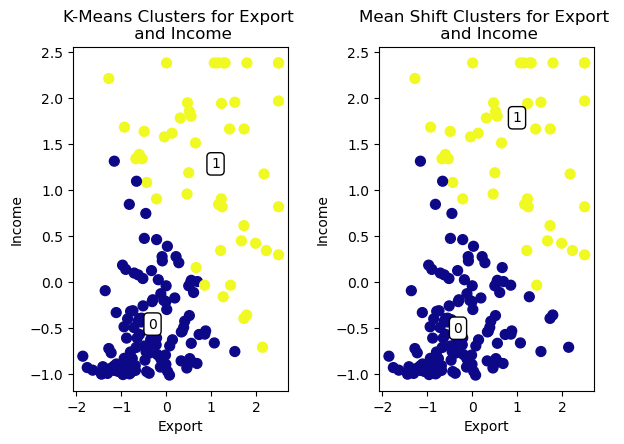

In [23]:
ms = MeanShift()
ms.fit(X_two)
mscenters = ms.cluster_centers_

fig, ax = plt.subplots(1, 2)

nm1 = Normalize(vmin =0, vmax = len(kmcenters)-1) # Count at 0 and count all the list of centriods minus 1

ax[0].scatter(X_two[:,0], X_two[:,1], c = kmeans.predict(X_two[:,[0,1]]), s = 50, cmap = 'plasma', norm = nm1)

#for loop to label clusters
for i in range(kmcenters.shape[0]):
    ax[0].text(kmcenters[i,0], kmcenters[i,1], str(i), c ='black',
            bbox = dict(boxstyle = 'round', facecolor = 'white', edgecolor = 'black'))

ax[0].set_xlabel('Export')
ax[0].set_ylabel('Income')
ax[0].set_title('K-Means Clusters for Export \n and Income')

nm2 = Normalize(vmin =0, vmax = len(mscenters)-1) # Count at 0 and count all the list of centriods minus 1

ax[1].scatter(X_two[:,0], X_two[:,1], c = ms.predict(X_two[:,[0,1]]), s = 50, cmap = 'plasma', norm = nm2)

#for loop to label clusters
for i in range(mscenters.shape[0]):
    ax[1].text(mscenters[i,0], mscenters[i,1], str(i), c ='black',
            bbox = dict(boxstyle = 'round', facecolor = 'white', edgecolor = 'black'))

ax[1].set_xlabel('Export')
ax[1].set_ylabel('Income')
ax[1].set_title('Mean Shift Clusters for Export \n and Income')

plt.tight_layout(pad =2.0)

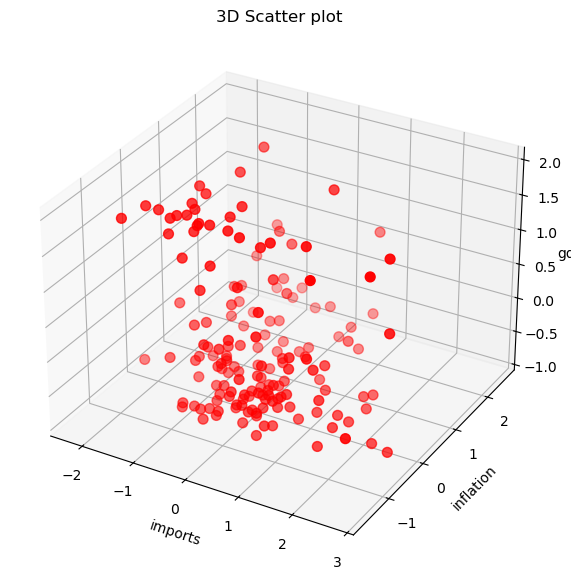

In [24]:
#Building model with 3 Economic Features  == Import, Inflation gdp
X_three_eco = X_scaled.iloc[:, [3,5,8]].values 


from mpl_toolkits import mplot3d
fig = plt.figure(figsize =(10,7))
ax = plt.axes(projection='3d')
ax.grid()

ax.scatter(X_three_eco[:,0], X_three_eco[:,1], X_three_eco[:,2], c= 'r', s =50)

ax.azim = -60
ax.dist = 10
ax.eleve = 10

plt.title('3D Scatter plot')
ax.set_xlabel(X_scaled.columns[3])
ax.set_ylabel(X_scaled.columns[5])
ax.set_zlabel(X_scaled.columns[8])

plt.show()

In [25]:
silhouette_scores = []

K = range(2, 11)

for k in K:
    kmeans = KMeans (n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_three_eco)
    score = silhouette_score(X_three_eco, kmeans.labels_)
    silhouette_scores.append(score)

# Print the K with the highest silhouette score
best_k = K[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters (based on silhouette score): {best_k}")

Optimal number of clusters (based on silhouette score): 3


In [26]:
# silhouette score optimal number of cluster is 3
kmeans = KMeans(n_clusters = 3, n_init = 'auto')

kmeans.fit(X_three[:,[0,1,2]])

kmcenters = kmeans.cluster_centers_
print('Centroids: \n', kmcenters)

Centroids: 
 [[-0.3774444  -0.59930731  0.21158945]
 [ 1.4582134  -0.18218109 -1.37791196]
 [-0.73215896  1.03530803  0.90364192]]


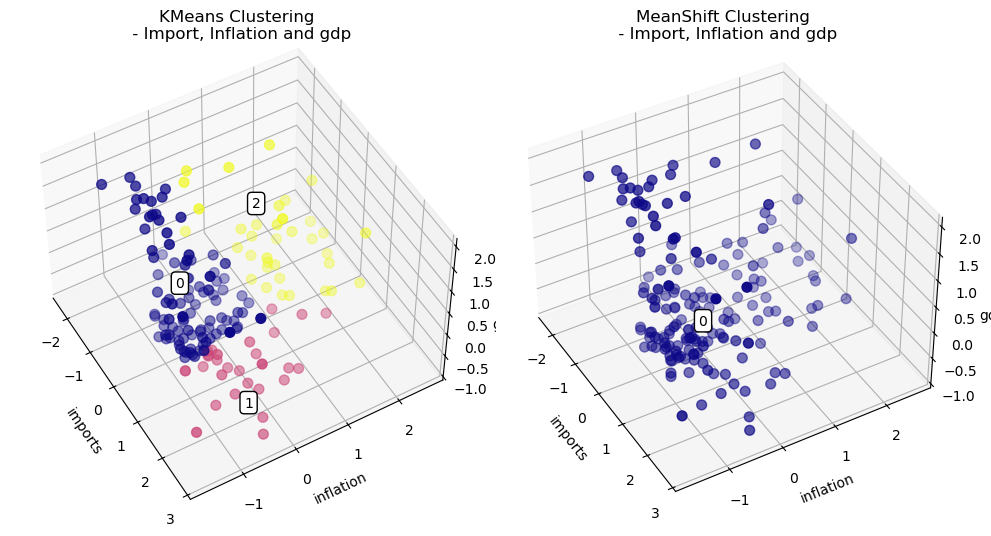

In [32]:
ms = MeanShift( bandwidth= 2)
ms.fit(X_three_eco[:,[0,1,2]])
mscenters = ms.cluster_centers_

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1, 2, 1, projection ='3d')

ax1.scatter(X_three_eco[:,0], X_three_eco[:,1], X_three_eco[:,2], c = kmeans.predict(X_three_eco[:,[0,1,2]]), s =50, cmap='plasma')

for i in range(kmcenters.shape[0]):
    ax1.text(kmcenters[i,0], kmcenters[i,1], kmcenters[i,2], str(i), c = "black", 
            bbox = dict(boxstyle = "round", facecolor = "white", edgecolor = "black"))
ax1.azim = -30
ax1.dist = -10
ax1.elev = 50
ax1.set_xlabel(X_scaled.columns[3])
ax1.set_ylabel(X_scaled.columns[5])
ax1.set_zlabel(X_scaled.columns[8])
ax1.set_title('KMeans Clustering \n - Import, Inflation and gdp')

#mean shift plot
ax2 = fig.add_subplot(1,2,2, projection ='3d')

ax2.scatter(X_three_eco[:,0], X_three_eco[:,1], X_three_eco[:,2], c = ms.predict(X_three_eco[:,[0,1,2]]), s =50, cmap='plasma')

for i in range(mscenters.shape[0]):
    ax2.text(mscenters[i,0], mscenters[i,1], mscenters[i,2], str(i), c = "black", 
            bbox = dict(boxstyle = "round", facecolor = "white", edgecolor = "black"))
ax2.azim = -30
ax2.dist = -10
ax2.elev = 40
ax2.set_xlabel(X_scaled.columns[3])
ax2.set_ylabel(X_scaled.columns[5])
ax2.set_zlabel(X_scaled.columns[8])
ax2.set_title('MeanShift Clustering \n - Import, Inflation and gdp')

fig.tight_layout(pad = 2.0)
plt.show()

#### Mixing up features: The clear visual separation in K-Means supports its selection as the preferred model for this dataset

##### Clustering based on the Country's Economic Strength and prosperity

In [33]:
# INCOME, INFLATION, GDP 
X = X_scaled.iloc[:, [4,5,8]].values
silhouette_scores = []

K = range(2, 11)

for k in K:
    kmeans = KMeans (n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

# Print the K with the highest silhouette score
best_k = K[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters (based on silhouette score): {best_k}")

Optimal number of clusters (based on silhouette score): 2


In [34]:
kmeans = KMeans(n_clusters = 2, n_init = 'auto')

kmeans.fit(X[:,[0,1,2]])

kmcenters = kmeans.cluster_centers_
print('Centroids: \n', kmcenters)

Centroids: 
 [[ 1.57719412 -0.56371353  1.67515009]
 [-0.48055133  0.17175647 -0.51039729]]


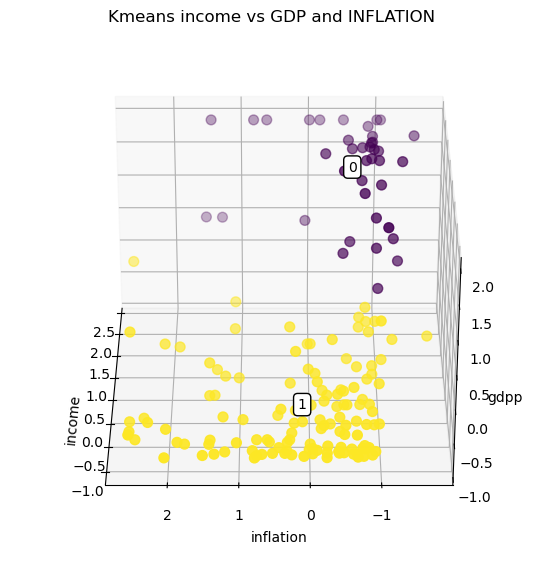

In [42]:
fig = plt.figure(figsize =(10,6))
ax = plt.axes(projection='3d')
ax.grid()

ax.scatter(X[:,0], X[:,1], X[:,2], c= kmeans.predict(X[:,[0,1,2]]), s =50)

for i in range(kmcenters.shape[0]):
    ax.text(kmcenters[i,0], kmcenters[i,1], kmcenters[i,2], str(i), c = "black", 
            bbox = dict(boxstyle = "round", facecolor = "white", edgecolor = "black"))

ax.azim = -180
ax.dist = 10
ax.eleve = 40

plt.title('Kmeans income vs GDP and INFLATION')
ax.set_xlabel(X_scaled.columns[4])
ax.set_ylabel(X_scaled.columns[5])
ax.set_zlabel(X_scaled.columns[8])
plt.tight_layout(pad = 2.0)
plt.show()

#### Based on Health and Population growth

In [43]:
# HEALTH, INCOME, TOTAL FERTILITY RATE
X = X_scaled.iloc[:, [2,4,7]].values
silhouette_scores = []

K = range(2, 11)

for k in K:
    kmeans = KMeans (n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

# Print the K with the highest silhouette score
best_k = K[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters (based on silhouette score): {best_k}")

Optimal number of clusters (based on silhouette score): 5


In [44]:
kmeans = KMeans(n_clusters = 5, n_init = 'auto')

kmeans.fit(X[:,[0,1,2]])

kmcenters = kmeans.cluster_centers_
print('Centroids: \n', kmcenters)

Centroids: 
 [[-0.44639136 -0.7980493   1.55223956]
 [ 1.21792543 -0.477312   -0.06429061]
 [ 1.17282673  1.46326311 -0.80465903]
 [-0.44809805 -0.30595591 -0.44434669]
 [-1.17084782  1.95178464 -0.56365533]]


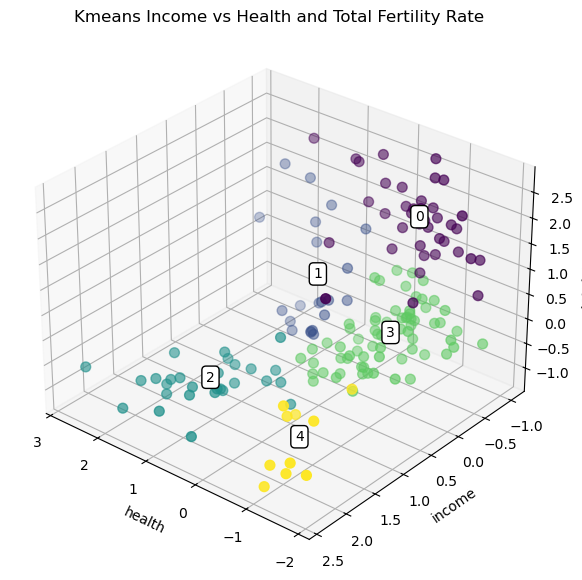

In [47]:
fig = plt.figure(figsize =(10,7))
ax = plt.axes(projection='3d')
ax.grid()

ax.scatter(X[:,0], X[:,1], X[:,2], c= kmeans.predict(X[:,[0,1,2]]), s =50)

for i in range(kmcenters.shape[0]):
    ax.text(kmcenters[i,0], kmcenters[i,1], kmcenters[i,2], str(i), c = "black", 
            bbox = dict(boxstyle = "round", facecolor = "white", edgecolor = "black"))

ax.azim = 130
ax.dist = 10
ax.eleve = 20

plt.title('Kmeans Income vs Health and Total Fertility Rate')
ax.set_xlabel(X_scaled.columns[2])
ax.set_ylabel(X_scaled.columns[4])
ax.set_zlabel(X_scaled.columns[7])

plt.show()

In [48]:
X_viz = pd.DataFrame ({ 
    'income': X_scaled['income'],
    'health': X_scaled['health'],
    'total_fer': X_scaled['total_fer']
})

#attaching country 
X_viz['country'] = df['country'].values

#adding cluster labels from trained model
X_viz['cluster'] = kmeans.labels_

X_viz.head()

,income,health,total_fer,country,cluster
0,-0.943936,0.296013,1.915276,Afghanistan,0
1,-0.395181,-0.091190,-0.862779,Albania,3
2,-0.199291,-0.985893,-0.036691,Algeria,3
3,-0.660984,-1.482114,2.141784,Angola,0
4,0.209637,-0.286671,-0.543003,Antigua and Barbuda,3


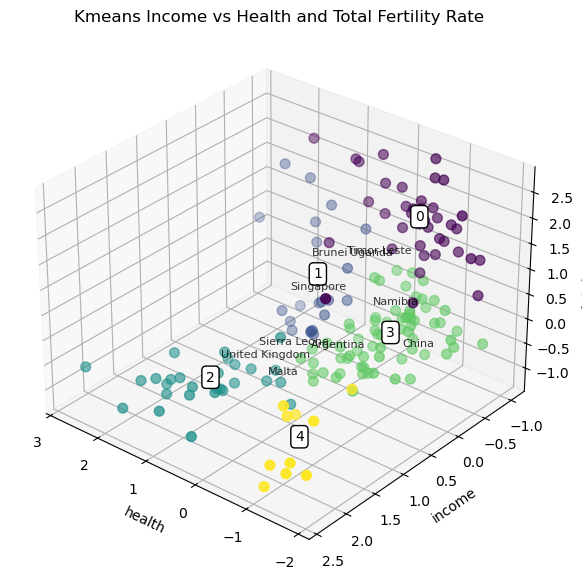

In [57]:
# adding countries
fig = plt.figure(figsize =(10,7))
ax = plt.axes(projection='3d')
ax.grid()

ax.scatter(X[:,0], X[:,1], X[:,2], c= kmeans.predict(X[:,[0,1,2]]), s =50)

#clusters 
for i in range(kmcenters.shape[0]):
    ax.text(kmcenters[i,0], kmcenters[i,1], kmcenters[i,2], str(i), c = "black", 
            bbox = dict(boxstyle = "round", facecolor = "white", edgecolor = "black"))

#countries
for cluster_id in X_viz['cluster'].unique():
    subset = X_viz[X_viz['cluster'] == cluster_id].sample(2, random_state = 42)
    for _, row in subset.iterrows():
        ax.text(row['income'], row['health'], row['total_fer'], row['country'],
                fontsize=8, c='black', alpha=0.8)
ax.azim = 130
ax.dist = 20
ax.eleve = 20

plt.title('Kmeans Income vs Health and Total Fertility Rate')
ax.set_xlabel(X_scaled.columns[2])
ax.set_ylabel(X_scaled.columns[4])
ax.set_zlabel(X_scaled.columns[7])

plt.show()